In [2]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
%matplotlib inline

In [81]:
random_state = 2018

In [82]:
np.random.seed(random_state)

# Read data

In [5]:
data = pd.read_csv('./data/train.csv', low_memory=False, skiprows=0)

In [6]:
images = data.loc[:, data.columns != "label"].values
labels = data["label"].values
n_classes = 10
labels_text = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

print("Dimensionality of images: {}".format(images.shape))
print("Dimensionality of labels: {}".format(labels.shape))

Dimensionality of images: (42000, 784)
Dimensionality of labels: (42000,)


# Data visualization

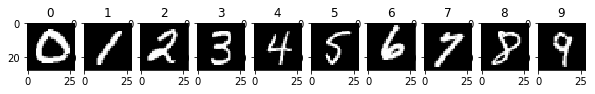

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

# Dimensinality reduction: PCA 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels)

pca_components = 100

pca = PCA(n_components=pca_components, random_state=random_state)
pca_fit = pca.fit(X_train)
X_train_pca = pca_fit.transform(X_train)
X_test_pca = pca_fit.transform(X_test)

# RandomForestClassifier with PCA

In [15]:
experiment_id = mlflow.create_experiment("RandomForestClassifier")
print("Experiment id: %d" % experiment_id)

In [17]:
print(experiment_id)

1


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 100
cv = 7
criterion = "gini"

with mlflow.start_run(experiment_id=experiment_id):

    clf = RandomForestClassifier(n_estimators=n_trees, criterion=criterion, random_state=random_state, n_jobs=-1)
    
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    clf.fit(X_train_pca, y_train)
    
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 0.9456 (+/- 0.0026)
Accuracy on test set: 0.9433


# GradientBoostingClassifier with PCA

In [18]:
experiment_id = mlflow.create_experiment("GradientBoostingClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 2


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

n_trees = 12
cv = 7
max_depth = 3

with mlflow.start_run(experiment_id=experiment_id):

    clf = GradientBoostingClassifier(n_estimators=n_trees,random_state=random_state, max_depth=max_depth)
    
    scores = cross_val_score(clf, X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    clf.fit(X_train_pca, y_train)
    
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees", n_trees)
    mlflow.log_param("cv", cv)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

KeyboardInterrupt: 

# Cascading

In [78]:
def append_cols(l):    
    return np.column_stack(l)

In [85]:
experiment_id = mlflow.create_experiment("Stacking on RandomForestClassifier")
print("Experiment id: %d" % experiment_id)

Experiment id: 3


In [75]:
enc = OneHotEncoder(sparse=False, n_values=n_classes)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

n_trees_n1 = 100
n_trees_n2 = 25
max_depth_n2 = 5
cv = 7
criterion = "gini"

with mlflow.start_run(experiment_id=experiment_id):

    # Stacking
    clf = RandomForestClassifier(n_estimators=n_trees_n1, criterion=criterion, random_state=random_state, n_jobs=-1)
    clf.fit(X_train_pca, y_train)
    
    train_probs = clf.predict_proba(X_train_pca)
    y_train_enc = enc.fit_transform(y_train.reshape(-1,1))
    
    tests_probs = clf.predict_proba(X_test_pca)
    y_test_predicted = clf.predict(X_test_pca)
    y_test_enc = enc.fit_transform(y_test_predicted.reshape(-1,1))
    
    new_X_train_pca = append_cols([y_train_enc, train_probs])
    new_X_test_pca = append_cols([y_test_enc, tests_probs])
    
    # Train
    clf = GradientBoostingClassifier(n_estimators=n_trees_n2,random_state=random_state, max_depth=max_depth_n2)
    scores = cross_val_score(clf, new_X_train_pca, y_train, cv=cv)
    cv_accuracy = scores.mean()
    cv_error = scores.std() * 2
    
    
    # Test    
    clf = GradientBoostingClassifier(n_estimators=n_trees_n2,random_state=random_state, max_depth=max_depth_n2)
    clf.fit(new_X_train_pca, y_train)
    test_accuracy = accuracy_score(y_test, clf.predict(new_X_test_pca))
    
    # Log params and metrics
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("n_trees_n1", n_trees_n1)
    mlflow.log_param("n_trees_n2", n_trees_n2)
    mlflow.log_param("max_depth_n2", max_depth_n2)
    mlflow.log_param("cv", cv)
    mlflow.log_param("pca_components", pca_components)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("cv_accuracy", cv_accuracy)
    mlflow.log_metric("cv_error", cv_error)

    print("Accuracy on cross-validation set: %0.4f (+/- %0.4f)" % (cv_accuracy, cv_error))
    print("Accuracy on test set: %0.4f" % test_accuracy)
    
    mlflow.sklearn.log_model(clf, "model")

Accuracy on cross-validation set: 1.0000 (+/- 0.0000)
Accuracy on test set: 0.9476


# Generate test predictions

In [48]:
test_data = pd.read_csv('./data/test.csv', low_memory=False, skiprows=0)

In [88]:
clf1 = RandomForestClassifier(n_estimators=n_trees_n1, criterion=criterion, random_state=random_state, n_jobs=-1)
clf1.fit(images, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)